In [1]:
import pandas as pd
from stock_prediction.commons import DEFAULT_DATA_EXTRACTION_OUTPUT_PATH
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_all_symbols = pd.read_csv(DEFAULT_DATA_EXTRACTION_OUTPUT_PATH)
df_all_symbols["Date"] = df_all_symbols["Date"].apply(lambda x: pd.Timestamp(x))
df_all_symbols = df_all_symbols.set_index("Date")

## Data Cleaning

In [3]:
first_index = df_all_symbols.isna().sum()

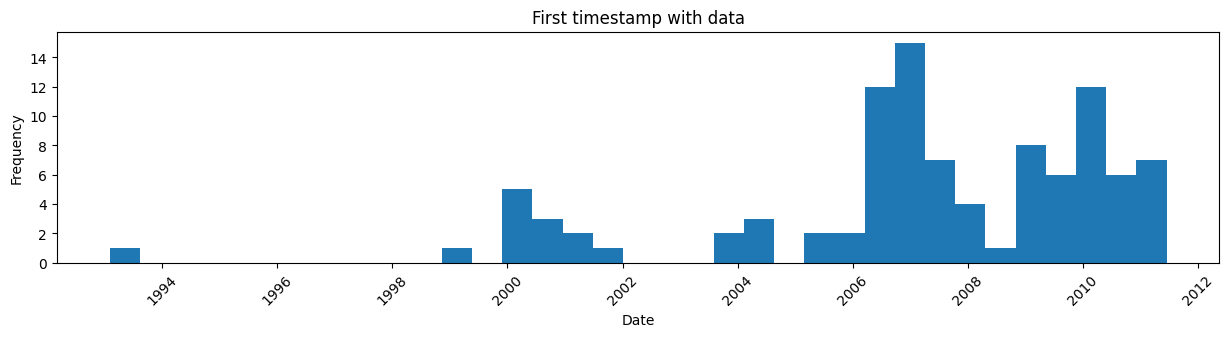

,Date
count,100
mean,2007-02-21 08:24:00+00:00
min,1993-02-01 00:00:00+00:00
25%,2006-05-08 00:00:00+00:00
50%,2007-05-09 12:00:00+00:00
75%,2009-11-19 12:00:00+00:00
max,2011-06-17 00:00:00+00:00


In [4]:
min_timestamps = pd.DataFrame(df_all_symbols.index[first_index])
plt.figure(figsize=(15,3))
plt.hist(min_timestamps, bins = 35)
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title("First timestamp with data")
plt.show()
min_timestamps.describe()


We can see that all symbols start more than 13 year ago, so it should be ok to just clip all the rows with NA. 

In [5]:
df_all_symbols_clipped = df_all_symbols[
    df_all_symbols.index >= df_all_symbols.index[first_index].max()
    ]


In [6]:
df_all_symbols_clipped.shape

(3318, 100)

In [7]:
df_all_symbols_clipped.isna().sum().describe()

count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

## Data Understanding

### Univariate Statistics

In [8]:
df_series_description = df_all_symbols_clipped.describe().T.drop("count", axis=1)
df_series_description 

,mean,std,min,25%,50%,75%,max
BIB,0.001086,0.030705,-0.196629,-0.016073,0.002044,0.018310,0.183601
CSM,0.000506,0.011135,-0.115944,-0.004183,0.000807,0.005745,0.094997
CURE,0.001489,0.030800,-0.298353,-0.013030,0.002107,0.017544,0.237088
DDM,0.000890,0.020991,-0.231843,-0.007419,0.001336,0.010586,0.224601
DSI,0.000515,0.011160,-0.120521,-0.003966,0.000637,0.005933,0.100190
...,...,...,...,...,...,...,...
VOT,0.000476,0.012777,-0.130237,-0.005257,0.000937,0.007075,0.105889
VTHR,0.000493,0.010801,-0.094494,-0.003686,0.000603,0.005708,0.088787
XHE,0.000454,0.013503,-0.085537,-0.006152,0.000895,0.007921,0.093513
XMMO,0.000601,0.013229,-0.139295,-0.005510,0.001033,0.007505,0.104187


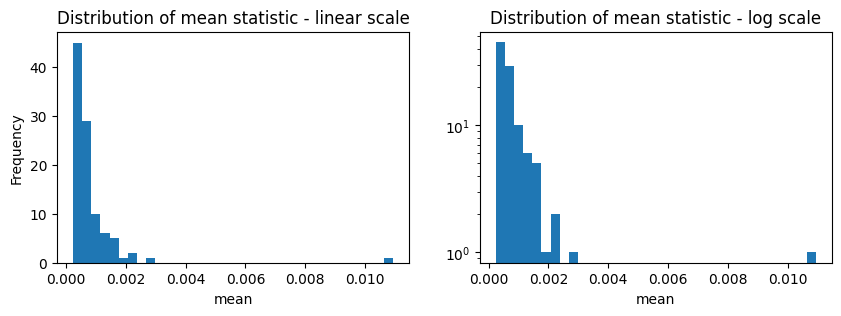

count    100.000000
mean       0.000849
std        0.001106
min        0.000235
25%        0.000503
50%        0.000559
75%        0.000869
max        0.010936
Name: mean, dtype: float64


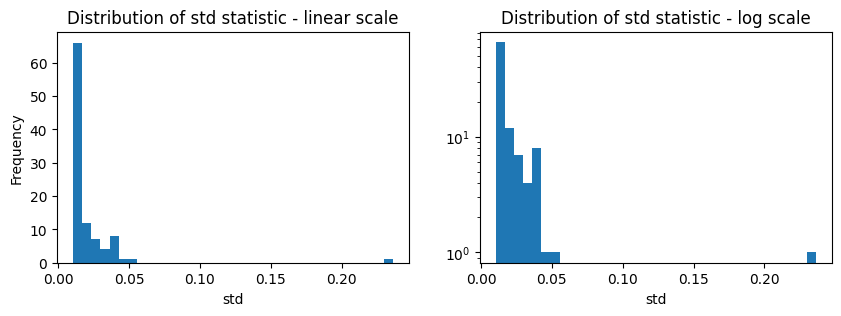

count    100.000000
mean       0.020180
std        0.023859
min        0.010310
25%        0.011760
50%        0.013630
75%        0.020888
max        0.236381
Name: std, dtype: float64


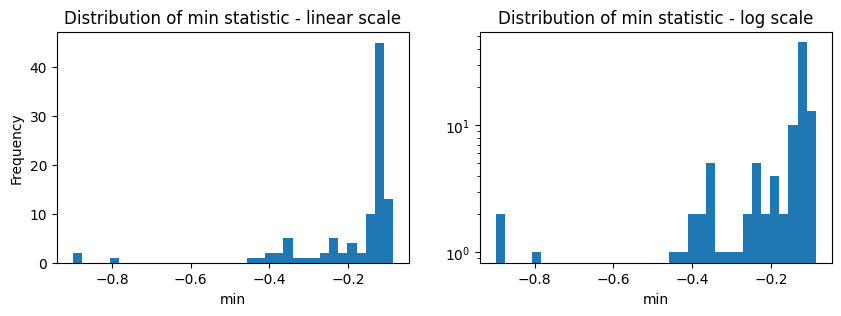

count    100.000000
mean      -0.190934
std        0.148752
min       -0.898880
25%       -0.203009
50%       -0.127630
75%       -0.117231
max       -0.085537
Name: min, dtype: float64


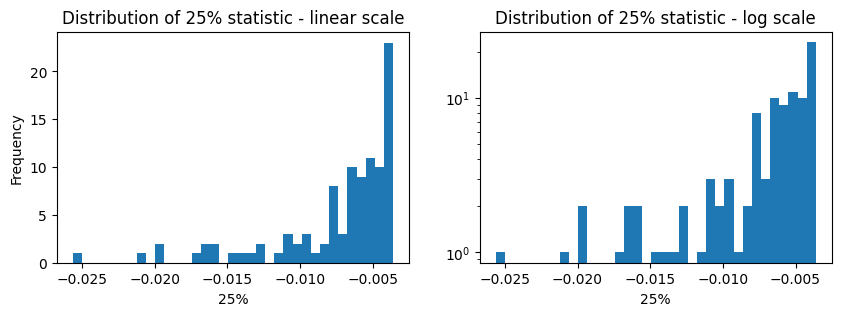

count    100.000000
mean      -0.007431
std        0.004439
min       -0.025634
25%       -0.008216
50%       -0.005843
75%       -0.004295
max       -0.003598
Name: 25%, dtype: float64


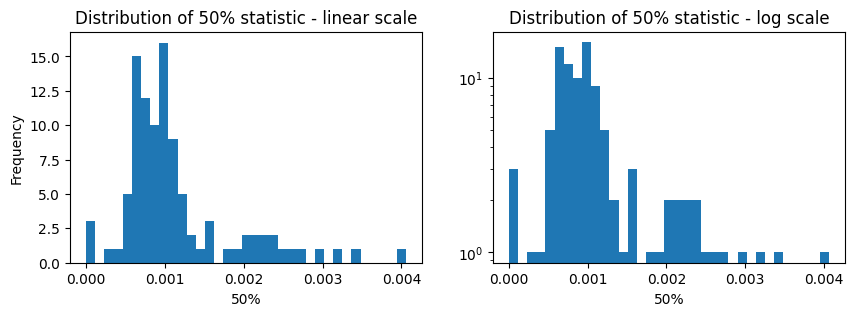

count    100.000000
mean       0.001141
std        0.000732
min        0.000000
25%        0.000699
50%        0.000956
75%        0.001242
max        0.004062
Name: 50%, dtype: float64


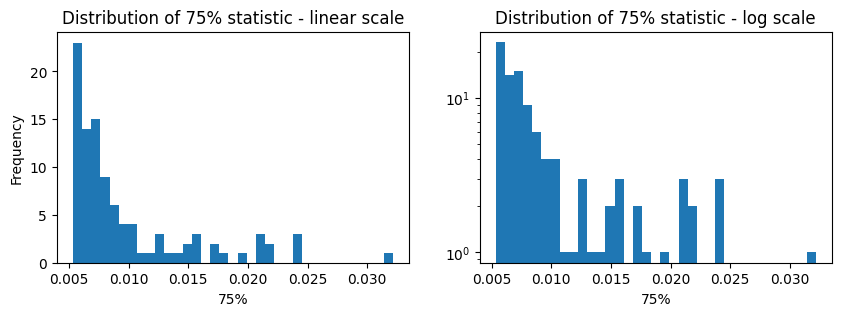

count    100.000000
mean       0.009824
std        0.005455
min        0.005328
25%        0.006280
50%        0.007462
75%        0.010779
max        0.032174
Name: 75%, dtype: float64


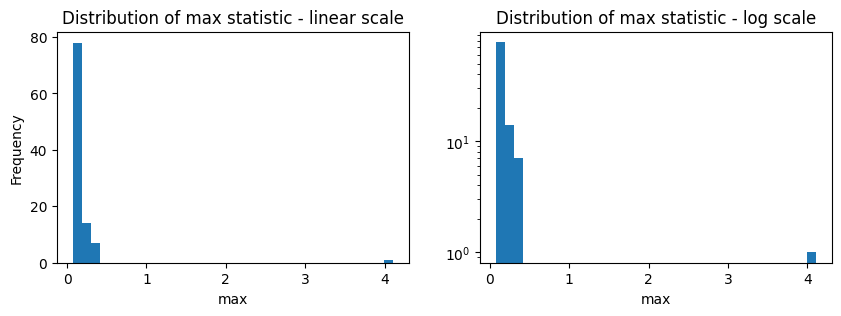

count    100.000000
mean       0.178098
std        0.403695
min        0.074038
25%        0.093507
50%        0.099232
75%        0.168318
max        4.106976
Name: max, dtype: float64


In [9]:
for col in df_series_description.columns:
    # Make a figure with two hists one with a line and one with a log scale side by side
    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.hist(df_series_description[col], bins=35)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {col} statistic - linear scale")
    plt.subplot(1, 2, 2)
    plt.hist(df_series_description[col], bins=35)
    plt.xlabel(col)
    plt.yscale("log")
    plt.title(f"Distribution of {col} statistic - log scale")
    plt.show()
    print(df_series_description[col].describe())
    

As we can see from the distributions above we have a skew towards positive returns, with the median of the various symbols having a distribution of positive values. This is consistent with the fact that we selected high performing symbols.

The distribution of std also shows that we have a distribution of daily volatility over the whole timespan of the dataset ranging from a minimum of about 0.01 with a mean value of about 0.02 and a max value of about 0.24 (i.e., typical daily variations of around 2% with a long tail up to large variations of about 24%).

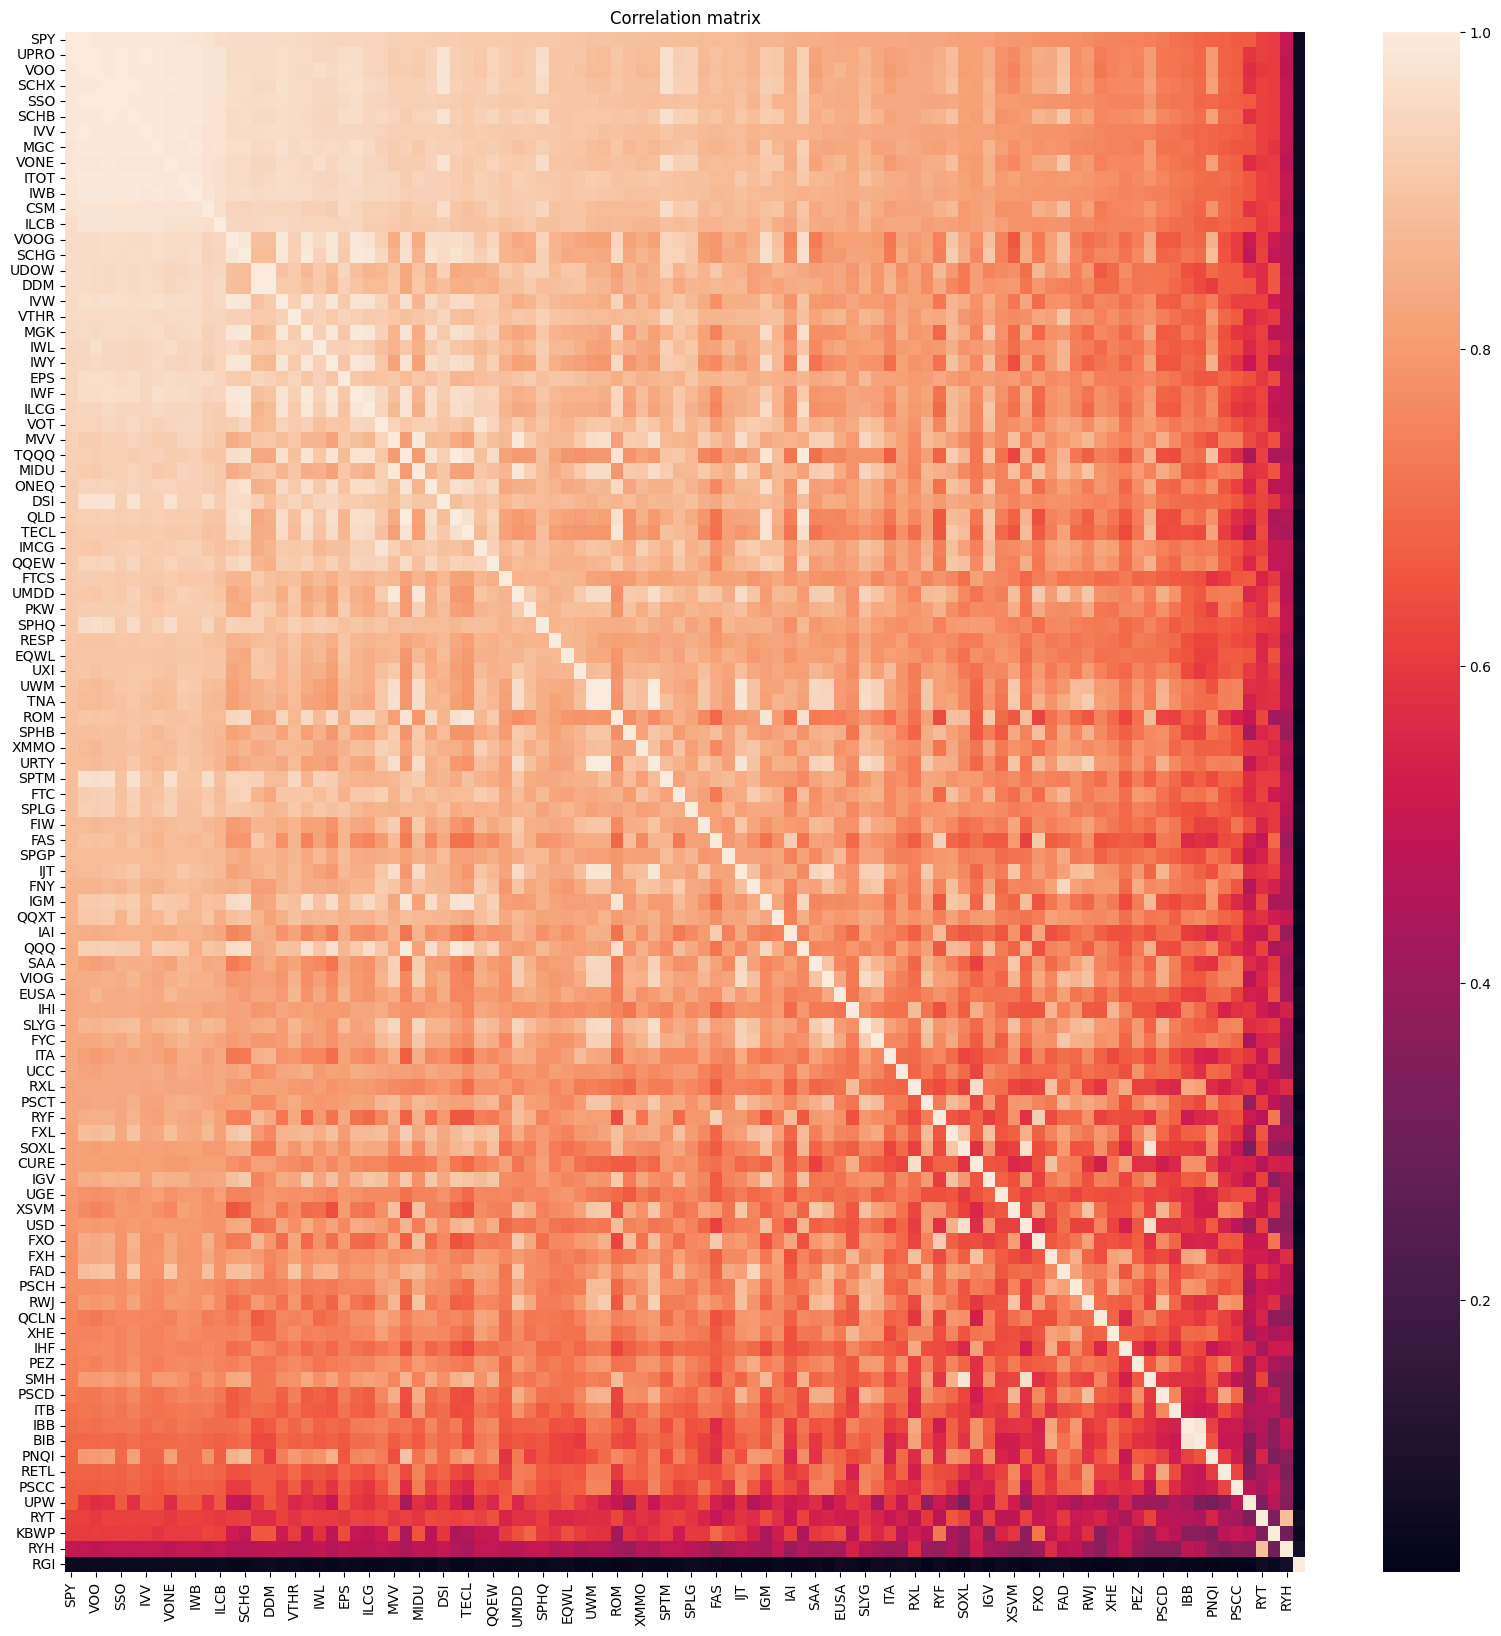

In [10]:
# Make a heatmap of the correlations withou labels

import seaborn as sns
df_corrs = df_all_symbols.corr()
cols_order = df_corrs.sort_values(by="SPY", ascending=False).index
plt.figure(figsize=(20,20))
sns.heatmap(df_corrs.loc[cols_order, cols_order], annot=False)
plt.title("Correlation matrix")
plt.show()

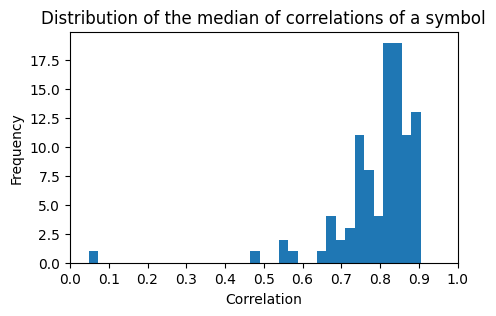

count    100.000000
mean       0.794738
std        0.110832
min        0.048662
25%        0.757203
50%        0.825256
75%        0.855039
max        0.905666
Name: 50%, dtype: float64

In [11]:
plt.figure(figsize=(5,3))
plt.hist(df_corrs.describe().T["50%"], bins=35)
plt.title("Distribution of the median of correlations of a symbol")
plt.xlabel("Correlation")
plt.ylabel("Frequency")
# set xticks to 0.1 increments up to and including 1
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()
df_corrs.describe().T["50%"].describe()

From the heatmap and the histogram we observe that most symbols have a high positive correlation though none are perfectly correlated (max of about 0.9) and there is a considerable tail with a median of median correlations of about 0.82 and a few values below 0.7.